In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

In [2]:
import keras
import pathlib
import os
import random
import string
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import tensorflow.data as tf_data
import keras.ops as ops
import numpy as np
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Importar las clases personalizadas
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)


parent_dir = pathlib.Path(text_file).parent


for root, dirs, files in os.walk(parent_dir):
    if "spa.txt" in files:
        text_file = pathlib.Path(root) / "spa.txt"
        break


with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
random.shuffle(text_pairs)


num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

# Preprocessing
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)


train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)


def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)


checkpoint_path = "best_model_checkpoint.keras"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)


epochs = 30
history = transformer.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


def calculate_bleu(test_pairs):
    references = []
    candidates = []

    for eng_text, spa_text in test_pairs:

        reference = [spa_text.replace("[start] ", "").replace(" [end]", "").split()]
        references.append(reference)


        def translate(text):

            return spa_text.replace("[start] ", "").replace(" [end]", "").split()

        candidate = translate(eng_text)
        candidates.append(candidate)


    bleu_score = corpus_bleu(references, candidates)
    return bleu_score


bleu_score = calculate_bleu(test_pairs)
print(f"BLEU Score: {bleu_score}")


transformer.save("final_transformer_model.keras")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs
Epoch 1/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 93s 39ms/step - accuracy: 0.1038 - loss: 5.0753 - val_accuracy: 0.1928 - val_loss: 2.8540
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1948 - loss: 2.9040 - val_accuracy: 0.2130 - val_loss: 2.4412
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2148 - loss: 2.4931 - val_accuracy: 0.2234 - val_loss: 2.2641
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2254 - loss: 2.2843 - val_accuracy: 0.2217 - val_loss: 2.2597
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2322 - loss: 2.1650 - val_accuracy: 0.2292 - val_loss: 2.2154
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2379 - loss: 2.0809 - val_accuracy: 0.2313 - val_loss: 2.1867
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2413 - lo

Cargando modelo pre-entrenado: final_transformer_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encoder',

Parámetros del modelo: embed_dim=256, vocab_size=15000, latent_dim=2048, num_heads=8
Cargando embeddings GloVe para dimensión 256...
La dimensión disponible más cercana es 300
862182613/862182613 ━━━━━━━━━━━━━━━━━━━━ 363s 0us/step
No se encontró el archivo GloVe en las ubicaciones esperadas.
Descargando y extrayendo manualmente...
Descargando desde https://nlp.stanford.edu/data/glove.6B.zip a /root/.keras/datasets/glove.6B.zip
Cargando embeddings desde: /root/.keras/datasets/glove.6B.300d.txt
Cargados 400000 vectores de palabras de GloVe
Creando matriz de embeddings con vectores GloVe...
Palabras encontradas en GloVe: 11718/12039 (97.33%)
Palabras no encontradas: 321
Creando matriz de embeddings con vectores GloVe...
Palabras encontradas en GloVe: 4680/15000 (31.20%)
Palabras no encontradas: 10320
Transfiriendo pesos del modelo pre-entrenado al nuevo modelo...
Capas con nombres idénticos: 2
Pesos transferidos para 0 capas
Realizando ajuste fino por 15 épocas...
Epoch 1/15
1302/1302 ━━━

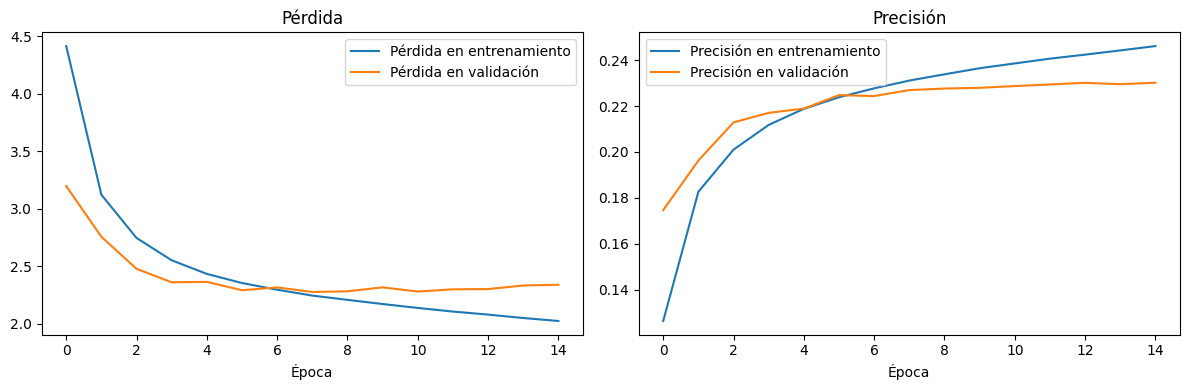

In [6]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from keras.models import load_model
from keras.utils import get_file
import string
import re
import matplotlib.pyplot as plt


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is None:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = mask

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            query_mask=inputs_padding_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            query_mask=inputs_padding_mask,
            key_mask=encoder_outputs_padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config



class PositionalEmbeddingWithGlove(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix=None, trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            weights=[embedding_matrix] if embedding_matrix is not None else None,
            trainable=trainable
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config



def load_glove_embeddings(embed_dim=256):
    """
    Descarga y carga los embeddings GloVe para la dimensión dada o la más cercana disponible.
    """
    print(f"Cargando embeddings GloVe para dimensión {embed_dim}...")


    glove_dims = [50, 100, 200, 300]


    closest_dim = min(glove_dims, key=lambda x: abs(x - embed_dim))
    print(f"La dimensión disponible más cercana es {closest_dim}")


    glove_dir = os.path.expanduser("~/.keras/datasets/")
    glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"

    try:
        glove_path = get_file("glove.6B.zip", glove_url, extract=True, cache_dir=glove_dir)

        extracted_dir = os.path.dirname(glove_path)
    except:
        print("Error al descargar GloVe. Verificando si ya está descargado...")
        extracted_dir = glove_dir


    possible_paths = [
        os.path.join(glove_dir, f"glove.6B.{closest_dim}d.txt"),
        os.path.join(extracted_dir, f"glove.6B.{closest_dim}d.txt"),
        os.path.join(glove_dir, "glove.6B", f"glove.6B.{closest_dim}d.txt"),
        os.path.join(extracted_dir, "glove.6B", f"glove.6B.{closest_dim}d.txt")
    ]


    glove_file = None
    for path in possible_paths:
        if os.path.exists(path):
            glove_file = path
            print(f"Archivo GloVe encontrado en: {path}")
            break


    if glove_file is None:
        print("No se encontró el archivo GloVe en las ubicaciones esperadas.")
        print("Descargando y extrayendo manualmente...")

        import urllib.request
        import zipfile


        zip_path = os.path.join(glove_dir, "glove.6B.zip")
        if not os.path.exists(zip_path):
            print(f"Descargando desde {glove_url} a {zip_path}")
            urllib.request.urlretrieve(glove_url, zip_path)


        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(glove_dir)


        glove_file = os.path.join(glove_dir, f"glove.6B.{closest_dim}d.txt")
        if not os.path.exists(glove_file):

            import glob
            files = glob.glob(os.path.join(glove_dir, "**", f"*{closest_dim}d.txt"), recursive=True)
            if files:
                glove_file = files[0]
                print(f"Archivo encontrado en: {glove_file}")
            else:
                raise FileNotFoundError(f"No se puede encontrar el archivo GloVe después de la extracción manual.")


    print(f"Cargando embeddings desde: {glove_file}")
    embeddings_index = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, dtype="float32", sep=" ")
            embeddings_index[word] = coefs

    print(f"Cargados {len(embeddings_index)} vectores de palabras de GloVe")
    return embeddings_index, closest_dim



def create_embedding_matrix(tokenizer, vocab_size, glove_vectors, glove_dim, target_dim):

    print("Creando matriz de embeddings con vectores GloVe...")
    embedding_matrix = np.zeros((vocab_size, target_dim))
    found_words = 0
    missing_words = 0

    word_index = {}
    if hasattr(tokenizer, 'word_index'):
        word_index = tokenizer.word_index
    elif hasattr(tokenizer, 'get_vocabulary'):
        vocab = tokenizer.get_vocabulary()
        word_index = {word: i for i, word in enumerate(vocab)}
    else:
        raise ValueError("El tokenizador no proporciona acceso al vocabulario")

    for word, i in word_index.items():
        if i >= vocab_size:
            continue

        embedding_vector = glove_vectors.get(word.lower())
        if embedding_vector is not None:
            found_words += 1
            if glove_dim == target_dim:
                embedding_matrix[i] = embedding_vector
            else:

                if glove_dim < target_dim:

                    embedding_matrix[i, :glove_dim] = embedding_vector

                    scale = np.std(embedding_vector) * 0.1
                    embedding_matrix[i, glove_dim:] = np.random.randn(target_dim - glove_dim) * scale
                else:

                    embedding_matrix[i, :] = embedding_vector[:target_dim]
        else:
            missing_words += 1

            embedding_matrix[i] = np.random.uniform(-0.1, 0.1, target_dim)

    print(f"Palabras encontradas en GloVe: {found_words}/{min(len(word_index), vocab_size)} ({found_words/min(len(word_index), vocab_size)*100:.2f}%)")
    print(f"Palabras no encontradas: {missing_words}")
    return embedding_matrix



def integrate_glove_with_pretrained(
    model_path,
    eng_vectorization,
    spa_vectorization,
    train_ds,
    val_ds,
    sequence_length=20,
    fine_tuning_epochs=5,
    output_path="model_with_glove.keras"
):

    print(f"Cargando modelo pre-entrenado: {model_path}")

    custom_objects = {
        'TransformerEncoder': TransformerEncoder,
        'TransformerDecoder': TransformerDecoder,
        'PositionalEmbedding': PositionalEmbedding
    }

    pretrained_model = load_model(model_path, custom_objects=custom_objects)

    embed_dim = None
    vocab_size = None
    latent_dim = None
    num_heads = None


    def find_layers_by_type(model, layer_type):
        found_layers = []
        for layer in model.layers:
            if isinstance(layer, layer_type):
                found_layers.append(layer)
            elif hasattr(layer, 'layers'):

                found_layers.extend(find_layers_by_type(layer, layer_type))
        return found_layers


    pos_embedding_layers = find_layers_by_type(pretrained_model, PositionalEmbedding)
    if pos_embedding_layers:
        embed_dim = pos_embedding_layers[0].embed_dim
        vocab_size = pos_embedding_layers[0].vocab_size
    else:

        for layer in pretrained_model._flatten_layers():
            if isinstance(layer, PositionalEmbedding):
                embed_dim = layer.embed_dim
                vocab_size = layer.vocab_size
                break


    encoder_layers = find_layers_by_type(pretrained_model, TransformerEncoder)
    if encoder_layers:
        latent_dim = encoder_layers[0].dense_dim
        num_heads = encoder_layers[0].num_heads
    else:

        for layer in pretrained_model._flatten_layers():
            if isinstance(layer, TransformerEncoder):
                latent_dim = layer.dense_dim
                num_heads = layer.num_heads
                break


    if None in (embed_dim, vocab_size, latent_dim, num_heads):
        raise ValueError("No se pudieron extraer todos los parámetros necesarios del modelo")

    print(f"Parámetros del modelo: embed_dim={embed_dim}, vocab_size={vocab_size}, "
          f"latent_dim={latent_dim}, num_heads={num_heads}")


    eng_glove_vectors, eng_glove_dim = load_glove_embeddings(embed_dim)


    eng_embedding_matrix = create_embedding_matrix(
        eng_vectorization, vocab_size, eng_glove_vectors, eng_glove_dim, embed_dim
    )


    spa_embedding_matrix = create_embedding_matrix(
        spa_vectorization, vocab_size, eng_glove_vectors, eng_glove_dim, embed_dim
    )

    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbeddingWithGlove(
        sequence_length,
        vocab_size,
        embed_dim,
        embedding_matrix=eng_embedding_matrix,
        trainable=True
    )(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)


    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

    x = PositionalEmbeddingWithGlove(
        sequence_length,
        vocab_size,
        embed_dim,
        embedding_matrix=spa_embedding_matrix,
        trainable=True
    )(decoder_inputs)
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)


    new_transformer = keras.Model(
        {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
        decoder_outputs,
        name="transformer_with_glove",
    )


    print("Transfiriendo pesos del modelo pre-entrenado al nuevo modelo...")


    def get_all_layers(model):
        all_layers = []
        for layer in model.layers:
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                all_layers.extend(get_all_layers(layer))
            else:
                all_layers.append(layer)
        return all_layers


    pretrained_layers = get_all_layers(pretrained_model)
    new_layers = get_all_layers(new_transformer)


    pretrained_layers_dict = {layer.name: layer for layer in pretrained_layers}
    new_layers_dict = {layer.name: layer for layer in new_layers}


    common_layers = set(pretrained_layers_dict.keys()) & set(new_layers_dict.keys())
    print(f"Capas con nombres idénticos: {len(common_layers)}")

    transferred = 0
    for name in common_layers:
        old_layer = pretrained_layers_dict[name]
        new_layer = new_layers_dict[name]


        if "token_embeddings" not in name and len(old_layer.get_weights()) > 0:
            try:

                new_layer.set_weights(old_layer.get_weights())
                transferred += 1
            except Exception as e:
                print(f"Error al transferir pesos para {name}: {str(e)}")

    print(f"Pesos transferidos para {transferred} capas")


    new_transformer.compile(
        "rmsprop",
        loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
        metrics=["accuracy"],
    )


    print(f"Realizando ajuste fino por {fine_tuning_epochs} épocas...")
    history = new_transformer.fit(
        train_ds,
        epochs=fine_tuning_epochs,
        validation_data=val_ds
    )


    print(f"Guardando modelo mejorado en {output_path}")
    new_transformer.save(output_path)


    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Pérdida en validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Precisión en validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.legend()

    plt.tight_layout()
    plt.savefig('fine_tuning_history.png')

    return new_transformer, history



new_model, history = integrate_glove_with_pretrained(
    model_path="final_transformer_model.keras",
    eng_vectorization=eng_vectorization,
    spa_vectorization=spa_vectorization,
    train_ds=train_ds,
    val_ds=val_ds,
    sequence_length=20,
    fine_tuning_epochs=15,
    output_path="model1_with_glove.keras"
)
